<a href="https://colab.research.google.com/github/flaviagaia/flaviagaia/blob/main/K_Means_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agrupamento de Textos com K-Means**

https://nbviewer.jupyter.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

Agrupamento de Texto com K-Means
No presente caderno, usaremos o algoritmo k-means, um algoritmo de agrupamento simples e popular não supervisionado, para agrupar os hinos nacionais do mundo em grupos diferentes.

O objetivo do K-means é simples: agrupar pontos de dados semelhantes e descobrir padrões subjacentes. Para atingir este objetivo, K-means procura um número fixo definido (k) de centróides em um conjunto de dados. Um centróide se refere a um cluster, que é uma coleção de pontos de dados agregados devido a certas semelhanças entre si. O "meio" no K-meio refere-se à média dos dados; ou seja, encontrar o centróide. E o algoritmo é dito não supervisionado porque não temos conhecimento prévio com relação aos grupos ou classes de nosso conjunto de dados, ou seja, encontraremos os grupos subjacentes em nosso conjunto de dados!

Abaixo podemos visualizar o algoritmo. Os centróides verdes combinam os pontos de dados mais próximos de cada um e formam clusters, então cada centróide se move para o centro de cada grupo respectivo e combina novamente os pontos de dados mais próximos entre si.

**Passos:**

1. Explore nossa coleção de hinos nacionais (corpus)
2. Projete o conjunto de dados para obter o melhor desempenho do algoritmo K-means
3. Execute o algoritmo várias vezes, cada vez testando com um número diferente de clusters
4. Use métricas diferentes para visualizar nossos resultados e encontrar o melhor número de clusters (ou seja, por que um total de clusters X é melhor do que um total de clusters Y)
5. Análise de Cluster

Métricas utilizadas para determinar o melhor número de militantes:

Método do cotovelo
Pontuação da silhueta

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 17.0 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 49.5 MB/s 


In [ ]:
!pip install Unidecode

     |████████████████████████████████| 235 kB 16.0 MB/s 


In [ ]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [ ]:
data = pd.read_csv('/content/anthems.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)

continents = ['Europe', 'South_America', 'North_America']
data = data.loc[data['continent'].isin(continents)]
data.head(6)

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."
5,Belgium,BE,BEL,Europe,"O dear Belgium, O holy land of the fathers Ã¢â..."


In [ ]:
corpus = data['anthem'].tolist()
corpus[18][0:447]

"O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂ\x81rpÃƒÂ¡d our hero's "

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [ ]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('/content/countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('/content/nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('/content/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

'lord bless nation grace bounti extend guard arm strife enemi long torn ill fate bring time relief nation suffer sin past futur brought ancestor carpathian holi peak beauti homeland bendeguz son flow river tisza danub afarpafa!d hero descend root bloom plain kun ripen wheat grape field tokaj drip sweet nectar flag plant wild turk earthwork mafa!tyafa! grave armi whimper vienna proud fort sin anger gather bosom struck lightn thunder cloud plunder mongol arro'

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

80 rows


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
sacr,0.321205,0.000000,0.000000,0.000000,0.097195,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.050846,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047180,0.000000,0.0,0.0,0.0,0.000000,0.0,0.109788,0.054963,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.062291,0.0,0.000000,0.000000,0.054294,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
proclaim,0.287718,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.086726,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
flag,0.246137,0.125613,0.000000,0.068841,0.074480,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.038963,0.0,0.00000,0.0,0.043321,0.0,0.036701,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.078881,0.10607,0.0,0.00000,0.0,0.0,0.0,0.254530,0.000000,0.0,0.0,0.0,0.036154,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.021059,0.0,0.0,0.000000,0.041288,0.0,0.000000,0.095466,0.0,0.157953,0.000000,0.124816,0.049884,0.0,0.081550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
fatherland,0.236083,0.120481,0.075348,0.198087,0.000000,0.080527,0.0,0.0,0.0,0.0,0.0,0.071022,0.513875,0.045633,0.074743,0.0,0.16083,0.0,0.000000,0.0,0.000000,0.0,0.190747,0.181721,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076563,0.151317,0.00000,0.0,0.14182,0.0,0.0,0.0,0.244132,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.174283,0.0,0.161386,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.356564,0.000000,0.0,0.000000,0.000000,0.000000,0.047847,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
honour,0.200697,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090565,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.118243,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.112293,0.0,0.0,0.0,0.000000,0.143043,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.239422,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.061013,0.0,0.099742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082598,0.0,0.154834


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
sacr,0.321205,0.000000,0.000000,0.000000,0.097195,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.050846,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047180,0.000000,0.0,0.0,0.0,0.000000,0.0,0.109788,0.054963,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.062291,0.0,0.000000,0.000000,0.054294,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
proclaim,0.287718,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.086726,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
flag,0.246137,0.125613,0.000000,0.068841,0.074480,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.038963,0.0,0.00000,0.0,0.043321,0.0,0.036701,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.078881,0.10607,0.0,0.00000,0.0,0.0,0.0,0.254530,0.000000,0.0,0.0,0.0,0.036154,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.021059,0.0,0.0,0.000000,0.041288,0.0,0.000000,0.095466,0.0,0.157953,0.000000,0.124816,0.049884,0.0,0.081550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
fatherland,0.236083,0.120481,0.075348,0.198087,0.000000,0.080527,0.0,0.0,0.0,0.0,0.0,0.071022,0.513875,0.045633,0.074743,0.0,0.16083,0.0,0.000000,0.0,0.000000,0.0,0.190747,0.181721,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076563,0.151317,0.00000,0.0,0.14182,0.0,0.0,0.0,0.244132,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.174283,0.0,0.161386,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.356564,0.000000,0.0,0.000000,0.000000,0.000000,0.047847,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
honour,0.200697,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090565,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.118243,0.0,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.112293,0.0,0.0,0.0,0.000000,0.143043,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.239422,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.061013,0.0,0.099742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082598,0.0,0.154834


In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [ ]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [ ]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()


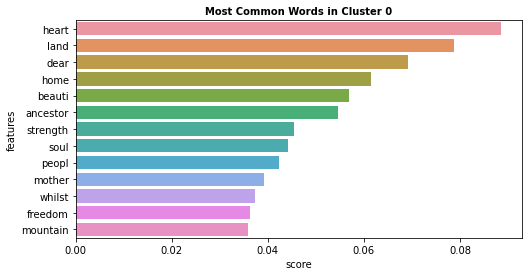

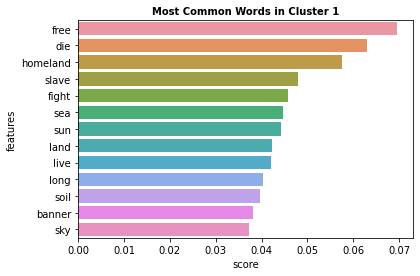

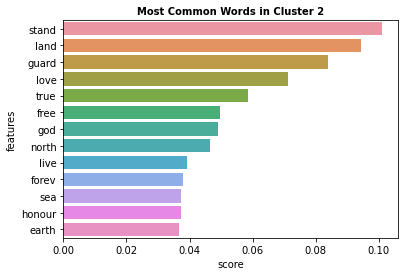

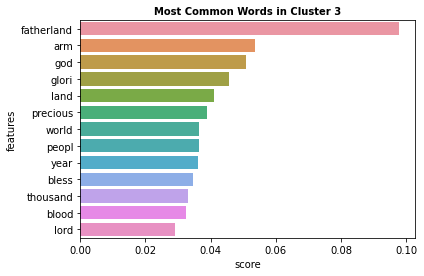

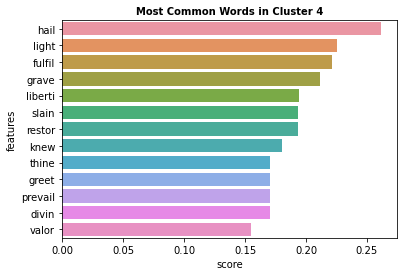

In [ ]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

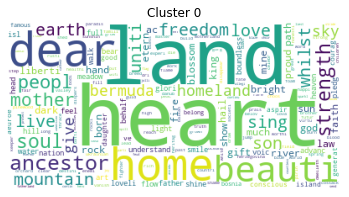

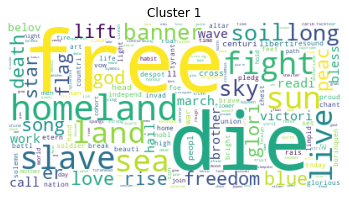

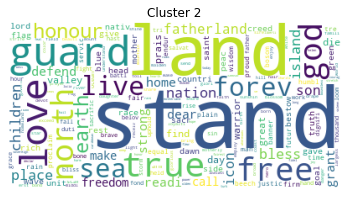

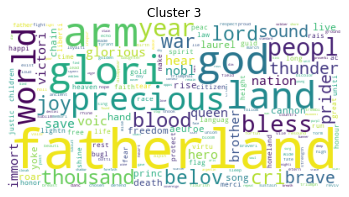

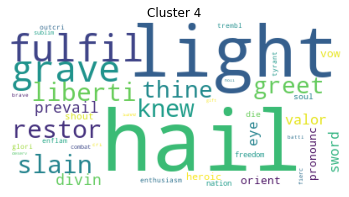

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

,country,alpha-2,alpha-3,continent,anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",2
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",1
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",0
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",2
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",1


In [ ]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'datasets/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3

SyntaxError: ignored

In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m

NameError: ignored